In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [3]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [5]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [6]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

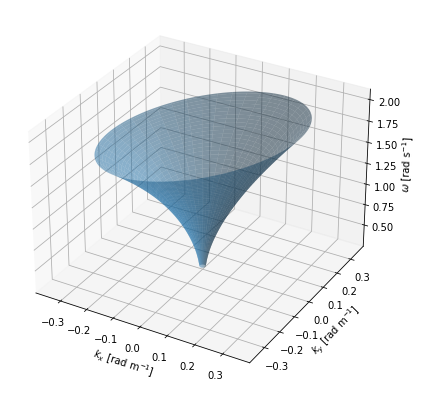

In [7]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [127]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta

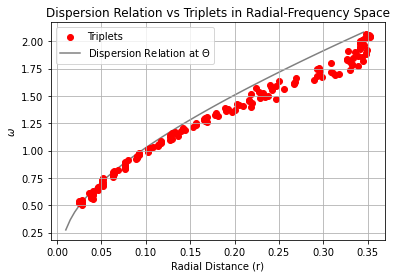

In [128]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

# Past Triplet Distibution 

In [129]:
FFT_spec = spec3d.spectrum()

In [130]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] > threshold:
                indices.append((i, j))
    return indices

In [131]:
def use_triplet_disrtibution(threshold):
    at_w = np.array([1.75])
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        plt.scatter(k_above_energy, np.full_like(k_above_energy, at_w), color = 'red', s = 1)

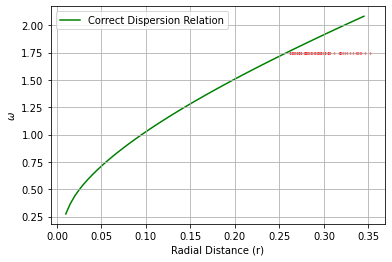

In [132]:
use_triplet_disrtibution(0.1)

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [45]:
def use_triplet_disrtibution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution
    
        threshold   float
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    '''
    
    
    avg_k = []
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        avg_k.append(sum(k_above_energy)/len(k_above_energy))
        
    return avg_k, k_above_energy

In [50]:
def find_indices_thresh(array, threshold_array):
    all_indices = []  # stores all indices for all thresholds
    
    for t in threshold_array:
        indices = []
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j] > t:
                    indices.append((i, j))
        all_indices.append(indices)  # Store indices for the current threshold in the list
    
    return all_indices


In [58]:
def calculate_k(indices):
    k_values = []
    for sublist in indices:
        k_sublist = []
        for i, j in sublist:
            k = np.sqrt(spec3d.kx[i]**2 + spec3d.ky[j]**2)
            k_sublist.append(k)
        k_values.append(k_sublist)
    return k_values

# Calculate k values
k_values = calculate_k(indices)
k_values

[[0.2852465224580893,
  0.27867511469496364,
  0.2930476708429552,
  0.3056952328585095,
  0.3175863558794404,
  0.31834643599937157,
  0.31960921936228254,
  0.3295373293032112],
 [0.2930476708429552, 0.3175863558794404, 0.31960921936228254]]

In [59]:
average_values = [sum(inner) / len(inner) for inner in k_values]

# Print the result
for i, avg in enumerate(average_values):
    print(avg)

0.3059679851748529
0.31008108202822604


In [397]:
def find_indices_multi_thresh(array, threshold_array):
    all_indices = []  # stores all indices for all thresholds
    
    for t in threshold_array:
        indices = []
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j] > t:
                    indices.append((i, j))
        all_indices.append(indices)  # Store indices for the current threshold in the list
    
    return all_indices

In [398]:
def calculate_k(indices):
    k_values = []
    for sublist in indices:
        k_sublist = []
        for i, j in sublist:
            k = np.sqrt(spec3d.kx[i]**2 + spec3d.ky[j]**2)
            k_sublist.append(k)
        k_values.append(k_sublist)
    return k_values

In [532]:
def multiple_thresh_triplet_distribution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution for many different threshold values
    
    Input
    
        threshold   array
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    Output 
    
        avg_k_list    array 
                      average k values at that threshold
    
    '''

    results = []  # Create an empty list to store results for each at_w

    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_multi_thresh(energies, threshold)
        # threshold energy value 
        
        k_values = calculate_k(indices)
        
        # Check if len(inner) is greater than 0 before calculating averages
        valid_k_values = [inner for inner in k_values if len(inner) > 0]
        
        if valid_k_values:
            average_values = [sum(inner) / len(inner) for inner in valid_k_values]
            results.append(average_values)  # Append average_values to the results list
        
        
    return results

In [615]:
lots_threshold = np.arange(0.1, 15, 0.1)

In [616]:
omega_levels = np.arange(0.5, 2, 0.01)

In [617]:
c_list = []

for i in omega_levels:
    c = np.argmin(np.abs (disp_ww_for_theta - i) )
    c_list.append(c)

In [618]:
#disp_ww_for_theta[c_list]

In [619]:
#disp_r[c_list]

In [620]:
avg_k_at_each_thresh = multiple_thresh_triplet_distribution(omega_levels, lots_threshold)

In [621]:
avg_k_indices = []
m = 0

for m in range(len(omega_levels)):
    j = np.argmin(np.abs(multiple_thresh_triplet_distribution(np.array([omega_levels[m]]), lots_threshold) - disp_r[c_list[m]]))
    avg_k_indices.append(j)


In [622]:
selected_values = []

# Use a for loop to iterate over thresholds and indices
for i in range(len(avg_k_indices)):
    threshold_index = avg_k_indices[i]
    threshold_values = avg_k_at_each_thresh[i]
    
    # Extract the value at the specified index for the current threshold
    selected_values.append(threshold_values[threshold_index])


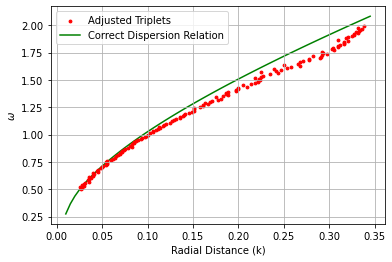

In [623]:
plt.scatter( selected_values  , omega_levels, color = 'red',  label = 'Adjusted Triplets', s = 8)

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (k)')
plt.ylabel('$\omega$')
plt.legend()